# Data Cleaning: Cafe Sales Dataset

This notebook demonstrates the process of cleaning and standardizing a cafe sales dataset. The steps include handling missing values, correcting data types, and visualizing the effects of cleaning operations.

In [243]:
# Initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Load the Dataset

Read the raw cafe sales data from a CSV file into a pandas DataFrame for cleaning and analysis.

In [244]:
# Load data
df = pd.read_csv(r"C:\Users\rymot\Desktop\Data Cleaning\data\dirty_cafe_sales.csv")
print(f"Dataset shape: {df.shape}")
df.head(3)

Dataset shape: (10000, 8)


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19


## Create a Clean Copy

Make a copy of the original DataFrame to preserve the raw data and perform cleaning operations on the duplicate.

In [245]:
#Create a clean copy
df_clean = df.copy()

In [246]:
# Convert relevant columns to numeric, coercing errors to NaN
df_clean['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df_clean['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')
df_clean['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')

## Check for Missing Values in Numeric Columns

Count the number of missing (NaN) values in the key numeric columns before cleaning.

In [247]:
nan_count_Quantity = df["Quantity"].isna().sum()
print(f"Number of NaN values in 'Quantity': {nan_count_Quantity}")
nan_count_Price_Per_Unit = df["Price Per Unit"].isna().sum()
print(f"Number of NaN values in 'Price Per Unit': {nan_count_Price_Per_Unit}")
nan_count_Total_Spent = df["Total Spent"].isna().sum()
print(f"Number of NaN values in 'Total Spent': {nan_count_Total_Spent}")


Number of NaN values in 'Quantity': 138
Number of NaN values in 'Price Per Unit': 179
Number of NaN values in 'Total Spent': 173


## Fill Missing Numeric Values

Fill missing values in 'Quantity', 'Price Per Unit', and 'Total Spent' by using available data from the other columns, ensuring consistency in the dataset.

In [248]:
# Fill missing Na in numerical values

df_clean.loc[df_clean["Total Spent"].isna() & ~df_clean["Price Per Unit"].isna() & ~df_clean["Quantity"].isna(), 
             "Total Spent"] = df_clean["Price Per Unit"] * df_clean["Quantity"]

df_clean.loc[df_clean["Price Per Unit"].isna() & ~df_clean["Total Spent"].isna() & ~df_clean["Quantity"].isna(), 
             "Price Per Unit"] = df_clean["Total Spent"] / df_clean["Quantity"]

df_clean.loc[df_clean["Quantity"].isna() & ~df_clean["Total Spent"].isna() & ~df_clean["Price Per Unit"].isna(), 
             "Quantity"] = df_clean["Total Spent"] / df_clean["Price Per Unit"]


## Visualize Remaining Missing Values

Visualize the number of missing values in each numeric column after attempting to fill them, to assess the effectiveness of the filling operation.

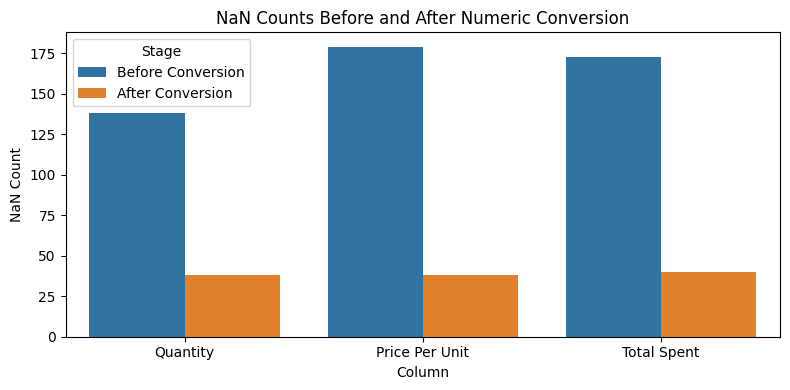

In [249]:
# Comparative bar plot: NaN counts before and after numeric conversion
nan_counts_before = [df['Quantity'].isna().sum(), df['Price Per Unit'].isna().sum(), df['Total Spent'].isna().sum()]
nan_counts_after = [df_clean['Quantity'].isna().sum(), df_clean['Price Per Unit'].isna().sum(), df_clean['Total Spent'].isna().sum()]

nan_compare_df = pd.DataFrame({
    'Column': ['Quantity', 'Price Per Unit', 'Total Spent'],
    'Before Conversion': nan_counts_before,
    'After Conversion': nan_counts_after
})

nan_compare_df_melted = nan_compare_df.melt(id_vars='Column', var_name='Stage', value_name='NaN Count')

plt.figure(figsize=(8,4))
sns.barplot(data=nan_compare_df_melted, x='Column', y='NaN Count', hue='Stage')
plt.title('NaN Counts Before and After Numeric Conversion')
plt.tight_layout()
plt.show()

## Standardize Missing and Invalid Categorical Values

Standardize missing or invalid entries in the 'Item', 'Payment Method', and 'Location' columns by replacing them with consistent placeholder values. This ensures uniformity and simplifies further analysis.

In [250]:
# Standardize missing values and count how many were replaced

# Items
item_missing = df_clean['Item'].isnull() | (df_clean['Item'] == '') | (df_clean['Item'] == 'UNKNOWN')
num_item_fixed = item_missing.sum()
if num_item_fixed > 0:
    df_clean.loc[item_missing, 'Item'] = 'Unknown Item'
    print(f"Standardized {num_item_fixed} 'Item' values to 'Unknown Item'.")

# Payment Methods
payment_issues = df_clean['Payment Method'].isnull() | (df_clean['Payment Method'] == '') | (df_clean['Payment Method'] == 'ERROR')
num_payment_fixed = payment_issues.sum()
if num_payment_fixed > 0:
    df_clean.loc[payment_issues, 'Payment Method'] = 'Unknown'
    print(f"Standardized {num_payment_fixed} 'Payment Method' values to 'Unknown'.")

# Locations
location_issues = df_clean['Location'].isnull() | (df_clean['Location'] == '') | (df_clean['Location'] == 'UNKNOWN')
num_location_fixed = location_issues.sum()
if num_location_fixed > 0:
    df_clean.loc[location_issues, 'Location'] = 'Unknown'
    print(f"Standardized {num_location_fixed} 'Location' values to 'Unknown'.")


Standardized 677 'Item' values to 'Unknown Item'.
Standardized 2885 'Payment Method' values to 'Unknown'.
Standardized 3603 'Location' values to 'Unknown'.


## Visualizing Standardization of Missing Values

The bar plot below shows how many missing or invalid values were standardized for each key column.

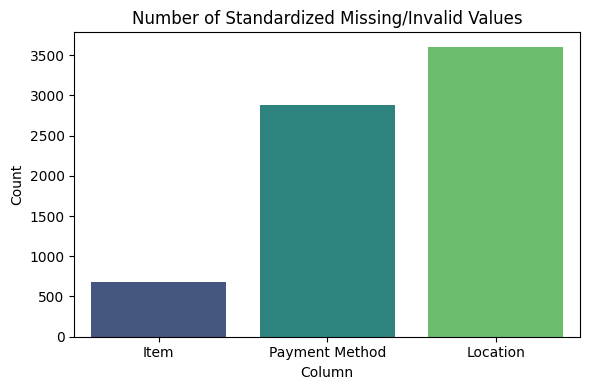

In [251]:

# Prepare data for visualization
standardized_counts = {
    'Item': num_item_fixed,
    'Payment Method': num_payment_fixed,
    'Location': num_location_fixed
}

fix_df = pd.DataFrame(list(standardized_counts.items()), columns=['Column', 'Standardized Count'])

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=fix_df, x='Column', y='Standardized Count', palette='viridis')
plt.title('Number of Standardized Missing/Invalid Values')
plt.ylabel('Count')
plt.xlabel('Column')
plt.tight_layout()
plt.show()

## Count Invalid Date Entries Before Cleaning:
Calculate and display the number of invalid (non-parsable) entries in the 'Transaction Date' column before any date cleaning is applied

In [ ]:
# Count invalid date entries before cleaning
invalid_dates_before = pd.to_datetime(df_clean['Transaction Date'], errors='coerce').isna().sum()
print(f"Number of invalid 'Transaction Date' entries before cleaning: {invalid_dates_before}")

Number of invalid 'Transaction Date' entries before cleaning: 460


## Clean and Validate Date Values

Convert the 'Transaction Date' column to datetime, replacing invalid entries with NaT (Not a Time), and filter out or review invalid dates for further cleaning.

In [253]:
# Replace invalid entries with NaT (Not a Time)
df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'], errors='coerce')

#Filter the invalid entries
invalid_dates = df_clean[df_clean['Transaction Date'].isna()]

## Parse Dates After Cleaning

Re-parse the 'Transaction Date' column to ensure all valid dates are in the correct datetime format after initial cleaning.

In [ ]:
df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'])

print("Missing values after cleaning")
df_clean.isnull().sum()


## Sample Cleaned Date Values

Display a random sample of cleaned 'Transaction Date' values to inspect the results of the date cleaning process.

In [256]:
# Sample some date values
print(df_clean['Transaction Date'].sample(10).values)

['2023-06-08T00:00:00.000000000' '2023-01-23T00:00:00.000000000'
 '2023-01-04T00:00:00.000000000' '2023-05-21T00:00:00.000000000'
 '2023-04-01T00:00:00.000000000' '2023-10-17T00:00:00.000000000'
 '2023-06-15T00:00:00.000000000' '2023-08-11T00:00:00.000000000'
 '2023-10-30T00:00:00.000000000' '2023-12-01T00:00:00.000000000']


## Visualizing Standardization of Transaction Dates

The following plot shows how many 'Transaction Date' entries were valid and how many were standardized (set to NaT) during the cleaning process. This helps illustrate the impact of standardizing invalid or unparsable date values in the dataset.

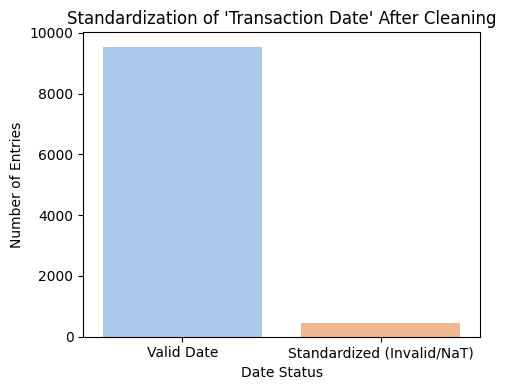

In [276]:
# Visualize standardization of 'Transaction Date' after cleaning

# Count valid and standardized (invalid) entries after cleaning
valid_dates_count = df_clean['Transaction Date'].notna().sum()
standardized_invalid_count = df_clean['Transaction Date'].isna().sum()

# Prepare data for visualization
date_standardization = pd.DataFrame({
    'Status': ['Valid Date', 'Standardized (Invalid/NaT)'],
    'Count': [valid_dates_count, standardized_invalid_count]
})

# Plot
plt.figure(figsize=(5,4))
sns.barplot(data=date_standardization, x='Status', y='Count', palette='pastel')
plt.title("Standardization of 'Transaction Date' After Cleaning")
plt.ylabel('Number of Entries')
plt.xlabel('Date Status')
plt.tight_layout()
plt.show()


## Missing Values in Original Data

Display the count of missing values in each column of the original dataset for comparison with the cleaned data.

In [257]:
df.isnull().sum()


Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

## Validate Calculated Totals

Recalculate 'Total Spent' from 'Quantity' and 'Price Per Unit' and compare with the existing values to validate the consistency of the cleaned data.

In [258]:
df_clean['Recalculated_Total'] = df_clean['Quantity'] * df_clean['Price Per Unit']
calculation_check = np.isclose(df_clean['Total Spent'], df_clean['Recalculated_Total'], rtol=1e-05)
print(f"Calculation validation: {calculation_check.sum()}/{len(df_clean)} rows correct")

Calculation validation: 9942/10000 rows correct
